In [1]:
!pip install numpy librosa matplotlib scikit-learn tensorflow ipython

In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Audio, display
from collections import Counter
import random

2025-07-29 18:40:22.424765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753814422.765609      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753814422.857378      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# PARAMETERS
SR = 22050
DURATION = 2.5
SAMPLES_PER_TRACK = int(SR * DURATION)
N_MELS = 128

In [4]:
# FEATURE EXTRACTION FUNCTION
def extract_features(file_path):
    try:
        signal, sr = librosa.load(file_path, sr=SR)
        if len(signal) < SAMPLES_PER_TRACK:
            pad_length = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, pad_length))
        else:
            signal = signal[:SAMPLES_PER_TRACK]
        mel = librosa.feature.melspectrogram(y=signal, sr=SR, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [5]:
# LOAD AND PREPROCESS DATA
data_dir = '/kaggle/input/gender-recognition-by-voiceoriginal/data'
X, y = [], []
file_paths = []

for label in ['male', 'female']:
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features)
                y.append(label)
                file_paths.append(file_path)

print("Label Distribution:", Counter(y))

X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

Label Distribution: Counter({'male': 10380, 'female': 5768})


In [6]:
# Show 1 random audio
i = np.random.randint(len(X))
signal, _ = librosa.load(file_paths[i], sr=SR)
print("Sample Gender:", y[i])
display(Audio(signal, rate=SR))

Sample Gender: male


In [7]:
# ENCODE LABELS
le = LabelEncoder()
y_int = le.fit_transform(y)
y_encoded = to_categorical(y_int, num_classes=2)

In [8]:
# CLASS WEIGHTS
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

Class Weights: {0: 1.3997919556171983, 1: 0.7778420038535645}


In [9]:
# SPLIT DATA
X_train, X_test, y_train, y_test, y_train_int, y_test_int = train_test_split(
    X, y_encoded, y_int, test_size=0.2, random_state=42, stratify=y_int
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (12918, 128, 108, 1) (12918, 2)
Test shape: (3230, 128, 108, 1) (3230, 2)


In [10]:
# MODEL DEFINITION
gender_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])
gender_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753814806.105559      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753814806.106211      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 106, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,072,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,091,010 (11.79 MB)

 Trainable params: 3,091,010 (11.79 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# TRAINING
checkpoint = ModelCheckpoint("gender_detection.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
history = gender_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    class_weight=class_weights
)

Epoch 1/30


I0000 00:00:1753814811.861512      79 service.cc:148] XLA service 0x77fd18004b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753814811.863003      79 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753814811.863025      79 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753814812.194867      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/404 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5238 - loss: 42.4598

I0000 00:00:1753814816.115698      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8515 - loss: 4.4531
Epoch 1: val_accuracy improved from -inf to 0.99659, saving model to gender_detection.h5
404/404 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8517 - loss: 4.4444 - val_accuracy: 0.9966 - val_loss: 0.0111
Epoch 2/30
401/404 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9925 - loss: 0.0245
Epoch 2: val_accuracy did not improve from 0.99659
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9925 - loss: 0.0246 - val_accuracy: 0.9950 - val_loss: 0.0119
Epoch 3/30
401/404 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9942 - loss: 0.0216
Epoch 3: val_accuracy did not improve from 0.99659
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9942 - loss: 0.0216 - val_accuracy: 0.9966 - val_loss: 0.0145
Epoch 4/30
401/404 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9938 - loss: 0.0191
Epoch 4: val_accuracy improved from 0.99659 to 0.99690, saving model to gender_detection.h5
404/404 ━━━━━━━━━━━━━━━━━

In [12]:
gender_model.save("gender_model.keras", save_format="keras")

In [13]:
# EVALUATION
y_pred_probs = gender_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_int, y_pred, target_names=['Female', 'Male']))
print("Testing Accuracy:", accuracy_score(y_test_int, y_pred))

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00      1154
        Male       1.00      1.00      1.00      2076

    accuracy                           1.00      3230
   macro avg       1.00      1.00      1.00      3230
weighted avg       1.00      1.00      1.00      3230

Testing Accuracy: 0.9975232198142415


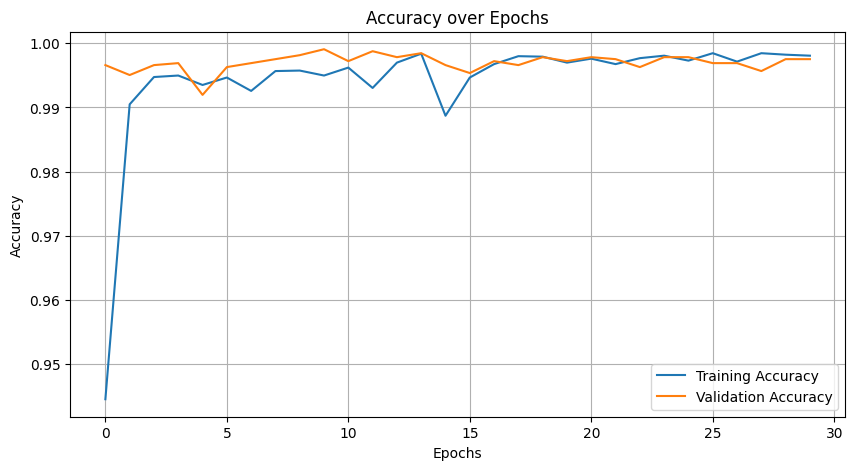

In [14]:
# PLOT TRAINING HISTORY
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# RANDOM 5 PREDICTIONS WITH AUDIO
indices = random.sample(range(len(X_test)), 5)
for i, idx in enumerate(indices):
    sample = np.expand_dims(X_test[idx], axis=0)
    pred = gender_model.predict(sample, verbose=0)[0]
    predicted = "Female" if np.argmax(pred) == 0 else "Male"
    actual = "Female" if np.argmax(y_test[idx]) == 0 else "Male"
    print(f"\nSample {i+1}")
    print(f"Predicted: {predicted}")
    print(f"Actual:    {actual}")

    # Play original audio
    original_index = np.where((X == X_test[idx]).all(axis=(1, 2, 3)))[0]
    if len(original_index) > 0:
        audio_path = file_paths[original_index[0]]
        signal, _ = librosa.load(audio_path, sr=SR)
        display(Audio(signal, rate=SR))


Sample 1
Predicted: Female
Actual:    Female



Sample 2
Predicted: Male
Actual:    Male



Sample 3
Predicted: Female
Actual:    Female



Sample 4
Predicted: Male
Actual:    Male



Sample 5
Predicted: Male
Actual:    Male
